In [57]:
from neo4j.v1 import GraphDatabase, basic_auth
import itertools
from joblib import Parallel, delayed
%matplotlib inline
import multiprocessing
import time
import plotly.plotly as py
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from plotly.tools import FigureFactory as FF

In [35]:
num_cores = multiprocessing.cpu_count()

In [36]:
driver = GraphDatabase.driver("bolt://localhost", auth=basic_auth("neo4j", "dmkm1234"))

In [37]:
session = driver.session()

In [28]:
t = time.time()
for i in range(0,400):
    session.run("MATCH (ar:Articles)-[:isArticle]-(s:Signatures)-[:isAuthor]-(au:Authors) WHERE ar.article_id in range (%s,%s) WITH (ar.article_id) as article, collect(au.author_id) as authorlist MATCH (au1:Authors),(au2:Authors) WHERE au1.author_id in authorlist and au2.author_id in authorlist MERGE (au1)-[r:isCoauthor]-(au2)" % (i*1000,(i+1)*1000))
elapsed = time.time() - t
print(elapsed)

0.131901025772


In [27]:
t = time.time()
for i in range(0,400):
    session.run("MATCH (ar:Articles)-[:isArticle]-(s:Signatures)-[:isAuthor]-(au:Authors) WHERE ar.article_id in range(%s,%s) WITH (ar.article_id) as article, collect(au.author_id) as authorlist MATCH (ar:Articles),(au:Authors) WHERE ar.article_id = article and au.author_id in authorlist MERGE (ar)<-[r:isWritten]-(au)"% (i*1000,(i+1)*1000) ) 
elapsed = time.time() - t
print(elapsed)

0.11606502533


In [92]:
t = time.time()
for i in range(0,98):
    session.run("MATCH (n:Authors)-[r:isCoauthor]-(m:Authors) WITH n.author_id as ntop, COUNT(r) as rank  order by rank desc skip %s limit %s WITH collect(ntop) as autop MATCH (au1:Authors)-[r:isCoauthor]-(au2:Authors) WHERE au1.author_id in autop and au2.author_id in autop MERGE (au1)-[r2:isMain]-(au2)" % (i*100,(i+1)*100))
elapsed = time.time() - t
print(elapsed)

0.0450179576874


In [9]:
t = time.time()
result0 = session.run("MATCH p = (a1:Authors)-[r:isMain*0]-(a2:Authors) WHERE ID(a1) < ID (a2)  WITH (a1.author_id) as aa1, (a2.author_id) as aa2, length(p) as d RETURN (aa1), (aa2), min(d)")
for line in result0:
    print (line)
elapsed = time.time() - t
print(elapsed)

1.04347085953


In [11]:
t = time.time()
result1 = session.run("MATCH p = (a1:Authors)-[r:isMain*1]-(a2:Authors) WHERE ID(a1) < ID (a2)  WITH (a1.author_id) as aa1, (a2.author_id) as aa2, length(p) as d RETURN (aa1), (aa2), min(d)")
elapsed = time.time() - t
print(elapsed)

0.00289607048035


In [12]:
t = time.time()
result2 = session.run("MATCH p = (a1:Authors)-[r:isMain*2]-(a2:Authors) WHERE ID(a1) < ID (a2)  WITH (a1.author_id) as aa1, (a2.author_id) as aa2, length(p) as d RETURN (aa1), (aa2), min(d)")
elapsed = time.time() - t
print(elapsed)

0.000517129898071


In [38]:
dist = np.matrix('0,0,0')

In [60]:
t = time.time()
result = session.run("MATCH p = (a1:Authors)-[r:isMain*1]-(a2:Authors) WHERE ID(a1) < ID (a2)  WITH (a1.author_id) as aa1, (a2.author_id) as aa2, length(p) as d RETURN (aa1), (aa2), min(d)")
for e in result:
    np.append(dist,[[e["aa1"],e["aa2"],e["min(d)"]]],axis=0)
elapsed = time.time() - t
print(elapsed)
len(dist)

11.5645999908


1

In [61]:
dist

matrix([[0, 0, 0]])

In [58]:
dendro = FF.create_dendrogram(dist)
dendro['layout'].update({'width':800, 'height':500})
py.iplot(dendro, filename='simple_dendrogram')

ValueError: The number of observations cannot be determined on an empty distance matrix.

In [54]:
dendrogram(
    dist,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

TypeError: Linkage matrix 'Z' must contain doubles.

In [55]:
dist

matrix([[0, 0, 0]])

In [80]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [53]:
result = session.run("MATCH (n:Articles)-[r:isWritten]-(m:Authors) WITH m.author_id as ntop, COUNT(r) as rank order by rank desc RETURN rank")
r1 = []
for line in result:
    r1.append(line["rank"])

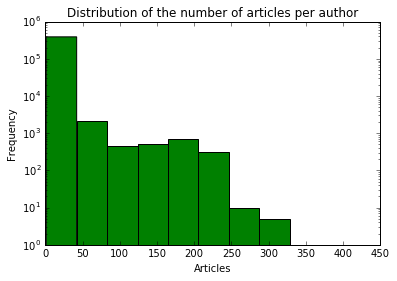

In [87]:
plt.hist(np.asarray(r1).flatten(), facecolor='green')
plt.title("Distribution of the number of articles per author")
plt.xlabel("Articles")
plt.ylabel("Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

In [88]:
result = session.run("MATCH (n:Authors)-[r:isCoauthor]-(m:Authors) WITH n.author_id as ntop, COUNT(r) as rank  order by rank desc RETURN rank")
r2=[]
for line in result:
    r2.append(line["rank"])

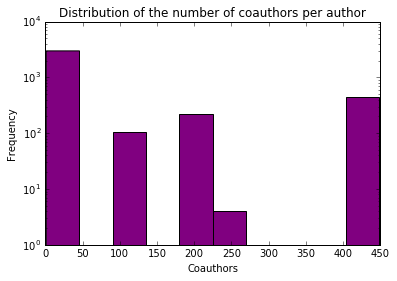

In [91]:
plt.hist(np.asarray(r2).flatten(), facecolor='purple')
plt.title("Distribution of the number of coauthors per author")
plt.xlabel("Coauthors")
plt.ylabel("Frequency")
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
session.close()